[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1W-iw0V84UOi7mnCSzD9gqEm096-wGbls)

# Notebook #5: misinformation on Twitter

## Description and requirements:

In this notebook, you will learn how to quantifies misinformation in Pakistani tweets by checking whether the urls contained in tweets match with any identified fake news sources.

A requirement for this code to work is to have the Newguard data containing a list of websites publishing misinformation about COVID-19. The data that can be requested [here](https://www.newsguardtech.com/coronavirus-misinformation-tracking-center/).

### Import modules

In [1]:
import os
import json
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path_to_data = './data'
path_to_sentiment = os.path.join(path_to_data, 'sentiment')
path_to_fake_news_domain = os.path.join(path_to_data, 'fake news domain')

### Define preprocessing functions

#### make_dirs

This function will create directories.

This function will take as an input:
- `dirs` list of directories paths to create

In [2]:
def make_dirs(dirs):
    for d in dirs:
        os.makedirs(d, exist_ok=True)

make_dirs([path_to_fake_news_domain])

#### save

This function will save a Pandas dataframe in a pickle format.

This function will take as an input:
- `df` The DataFrame to save
- `path` The path to save the file
- `name` The name of the saved file

In [3]:
def save(df, path, name):
    df.to_pickle(os.path.join(path, f'{name}.pkl'))

#### load_from_pickle

This function loads all saved pickle files to a DataFrame from a given path.

This function will take as an input:
- `path` The path to a folder containing all pickle files

This function will return a Pandas DataFrame containing all the files loaded.

In [4]:
def load_from_pickle(path):
    files = glob(os.path.join(path, '*.pkl'))
    return pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in files])


#### preprocess_domain

This function will load the `Newsguard_covid_fake.txt` from `path_to_fake_news_domain` and extract the domain name from each link.
Finally, it will save the file to `clean_domain.pkl`

In [5]:
def preprocess_domain():
    domains = pd.read_csv(os.path.join(path_to_fake_news_domain, 'Newsguard_covid_fake.txt'), sep='\n', header=None)
    domains.columns = ['domain']
    domains['name'] = domains['domain'].apply(lambda url: url.split('.')[-2])
    save(domains, path_to_fake_news_domain, 'clean_domains')

preprocess_domain()

#### get_string_from_entities

Since the URLs come in a dictionary shape, we define the following function to extract these URLs from the dictionary.

This function will receive:
- `df` a dataFrame to extract the `entities` from

It will return a Pandas series, where each value is a string representation of the urls.

In [6]:
def get_string_from_entities(df):
    return pd.Series(df['entities'].apply(lambda entity: json.dumps(entity.get('urls'))))

#### if_fake_url

After extracting the URL's from the `entities` column, we would like to check if we have a URL leading to a fake news site. To achieve this, we will define the following function.

This function takes as input a pandas DataFrame. It then loads the preprocessed domains `clean_domain.pkl`, and then it will go over every url in the DataFrame and will search for any Fake News domain in them. If found the tweet will be mark as a fake usign the value 1.
If it can't find any, it will then check if the url is empty of does it contain `twitter.com`. In that case, we would want to mark this tweet as irrelevant using -1.
Otherwise, we will mark it using 0, as to say that this tweet has an url, but it is not fake.

In [7]:
def if_fake_url(df):
    domains = load_from_pickle(path_to_fake_news_domain)
    return df['urls'].apply(lambda urls: 1 if any([dom in urls for dom in domains['domain']]) else -1 if urls == '{}' or 'twitter.com' in urls else 0)

Now will use the data from [Notebook #3: tweet sentiment analysis](3-sentiment-analysis.ipynb) that we already cleaned and analyze it.
A quick reminder that in the USA set we have:
- Total of 112781 tweets.
- The oldest tweet is from: Apr 05 2020.
- the most recent tweet is from: Oct 28 2020.
- Total of 113 unique users.

In [8]:
# Load the df from path_to_sentiment
df = load_from_pickle(path_to_sentiment)
# Fill all missing values with ""
df.fillna(value="''", inplace=True)
# Print the head of the df to show some content
df['clean_text'].head()

0              that why u out of the senate u are lost
1                                         hope u right
2                                       damn laughable
3     u got that right  that bush appointee is a li...
4                      they dont change no matter what
Name: clean_text, dtype: object

Next what we want to do is to get the entities from out tweets using the `get_string_from_entities` function, and then to go over all the tweets and mark them using the `if_fake_url`.
After this cell will execute, each tweet will be marked using a number:
- -1: if the tweet has no relevant URL.
- 1: if the tweet leads to fake news site
- -0: if the tweet has a URL, but it does not lead to fake news site

In [9]:
# Get urls from entities
df['urls'] = get_string_from_entities(df)
# Mark tweets to to see who contains any fakes
df['fake_news'] = if_fake_url(df)
df.set_index('created_at', inplace=True)

### Compute share of fake news links
We first filter all tweets that don't contain any URLs.

In [10]:
print(f"Total Number of fake url found is: {len(df[df['fake_news'] == 1])} out of {len(df[df['fake_news'] != -1])} tweets containing urls")
only_url = df[df['fake_news'] != -1]

Total Number of fake url found is: 95 out of 98133 tweets containing urls


We then use `.count()` on our DataFrame to count the number of tweets containing URLs, after sampling them using the `resample()` function.

In [11]:
only_url_total = pd.DataFrame(only_url['fake_news'].resample('M').count())
only_url_total.columns = ['total_monthly_urls']
only_url_total.index = [ind[:7] for ind in only_url_total.index.map(str)]
only_url_total.head()

,total_monthly_urls
2020-04,4977
2020-05,6919
2020-06,8657
2020-07,16494
2020-08,17837


Now get the monthly sum of the tweets.
`fake_news` column will refer to the number of shared URLs considered as fake news
Here we will use the `.sum()` function to calculate how much `fake_news` tweets we have.
Because we marked each fake url using a `1` and the rest as `0` we can use the sum function to achieve this goal.

In [12]:
monthly_fake_sum = pd.DataFrame(only_url['fake_news'].resample('M').sum())
monthly_fake_sum.index = only_url_total.index
monthly_fake_sum = pd.concat([monthly_fake_sum, only_url_total], axis=1)
monthly_fake_sum.head()

,fake_news,total_monthly_urls
2020-04,0,4977
2020-05,0,6919
2020-06,6,8657
2020-07,41,16494
2020-08,12,17837


We will use pandas `mean()` function to calculate the monthly mean of fake news urls.
We would like to see the results in percentages we will multiply the value by 100.
The monthly mean is the average number of tweets containing fake news URLs each month.

In [13]:
mean_monthly_fake = pd.DataFrame(only_url['fake_news'].resample('M').mean() * 100)
mean_monthly_fake.columns = ['monthly_fake_news_tweets_mean']
mean_monthly_fake.index = only_url_total.index
mean_monthly_fake = mean_monthly_fake.dropna()
mean_monthly_fake.head()

,monthly_fake_news_tweets_mean
2020-04,0.000000
2020-05,0.000000
2020-06,0.069308
2020-07,0.248575
2020-08,0.067276


### Plot results

Now to plot the data and save it, we define a final function:

This function will receive:
- `df` a dataFrame to plot the information
- `ylabel` a label for the y-axis
- `xlabel` a label for the x-axis
- `title` a title for the plot
- `rotation` a variable to determine whether to rotate the text
- `ylim` a range limit on the y-axis
- `legend` a boolean (True/False) to determine whether to display a legend or not

In [14]:
def bar_plot_and_save(df, ylabel, xlabel, title, rotation=0, ylim=None, legend=True):
    # Plot the data in a `bar` format
    axes = df.plot(kind="bar", figsize=(25, 10), subplots=False)
    # Set the labels and title
    axes.set_ylabel(ylabel, fontsize=14)
    axes.set_xlabel(xlabel)
    axes.set_title(title, fontsize=22, pad=20)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.legend(fontsize=14)
    # Go over each bar and display a text with the value above it
    for p in axes.patches:
        axes.annotate(np.round(p.get_height(), decimals=2), (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='center', rotation=rotation, xytext=(2, 20), textcoords='offset points')
    # Set a limit on the y axis if present
    if ylim is not None:
        plt.ylim(*ylim)
    # Remove the legend if not required
    if not legend:
        axes.legend().remove()
    # Save the figure to a file and display it
    plt.savefig(f"{'_'.join(title.split(' ')).lower()}", dpi='figure', bbox_inches="tight")
    plt.show()

We now plot the results:

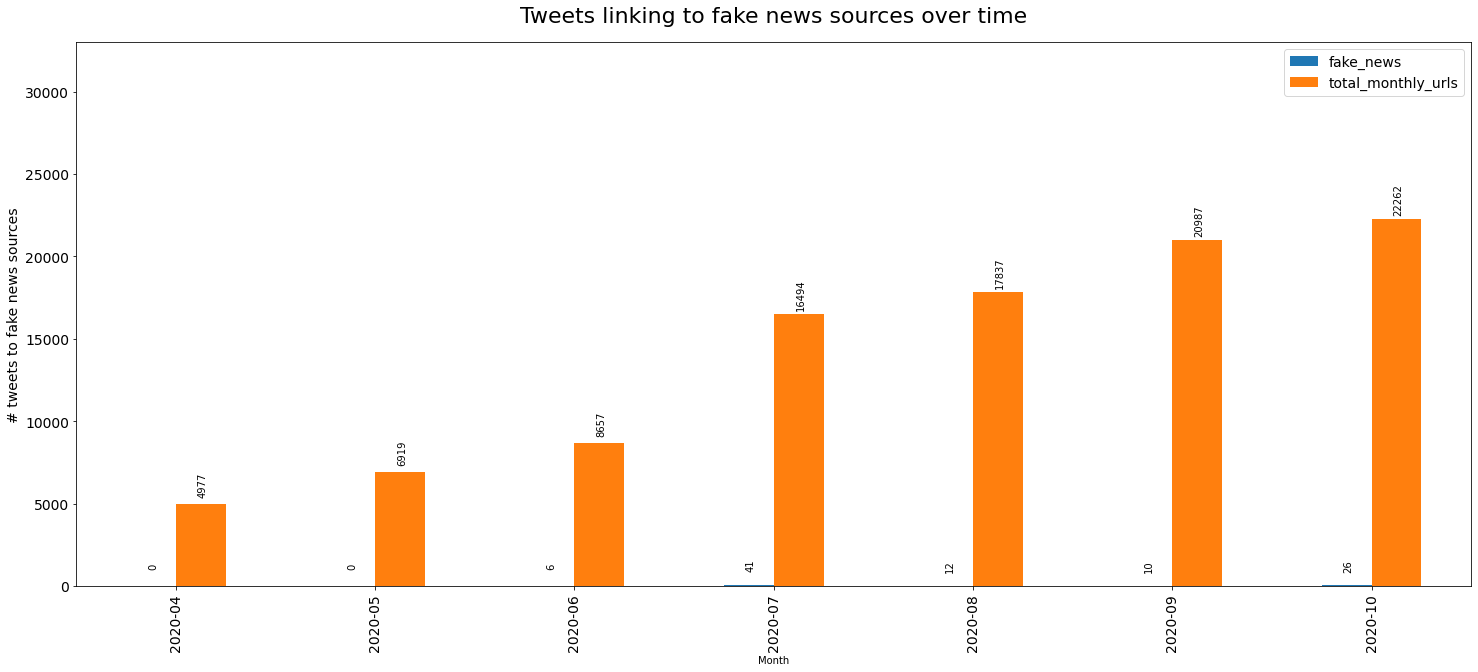

In [15]:
bar_plot_and_save(df=monthly_fake_sum, ylabel='# tweets to fake news sources', xlabel='Month',
                  title='Tweets linking to fake news sources over time',
                  rotation=90, ylim=[0, 33000], legend=True)

As we can see from the plot, there are a lot of URLs being shared and only a small percentage of them are from fake news sources.
We now look at the monthly share of tweets linking to fake news sources.

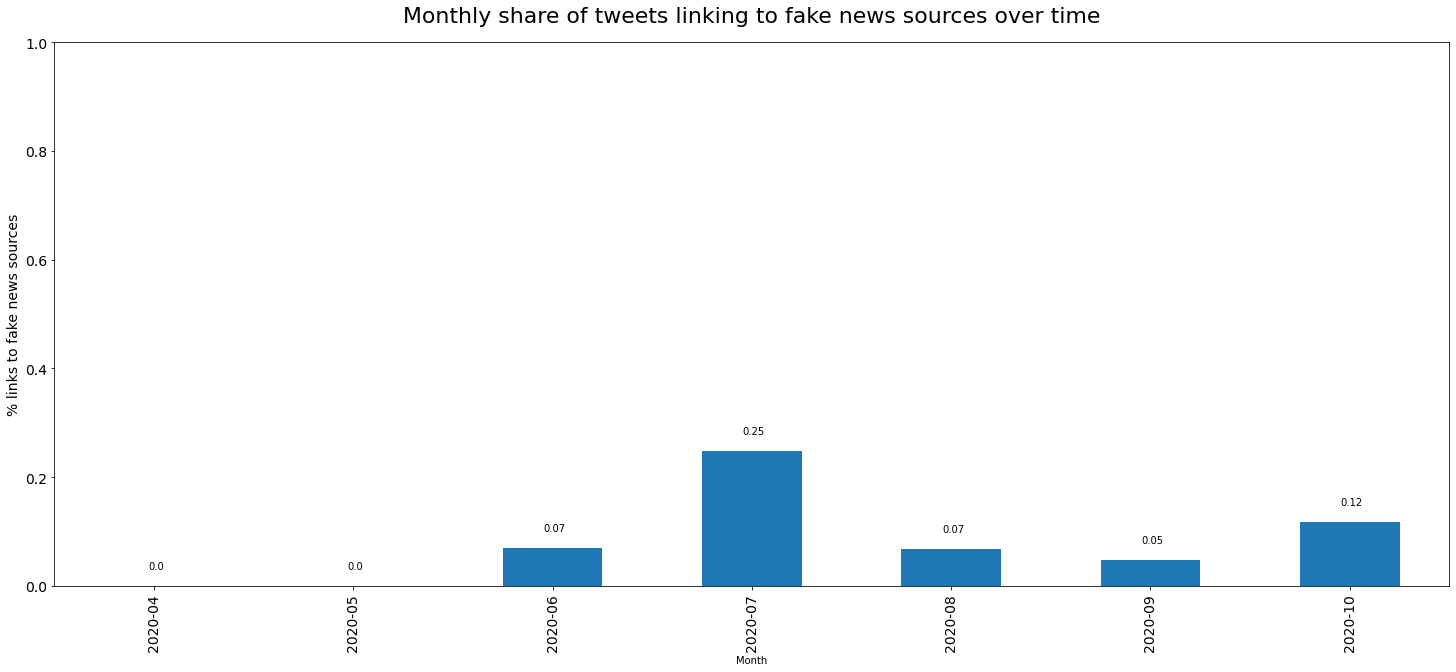

In [16]:
bar_plot_and_save(df=mean_monthly_fake, ylabel='% links to fake news sources',
                  xlabel='Month',title='Monthly share of tweets linking to fake news sources over time',
                  ylim=[0, 1], legend=False)

Now it is a lot clearer as to what happening.
It seems that we can see a slight increase in July.
Let's try and see what we can learn by looking at it closer.

In [19]:
mean_daily_fake = pd.DataFrame(only_url['fake_news'].resample('D').mean()['2020-07-01':'2020-07-31'] * 100)
mean_daily_fake.columns = ['daily_fake_news_tweets_mean']
mean_daily_fake.index = [ind[:10] for ind in mean_daily_fake.index.map(str)]
mean_daily_fake = mean_daily_fake.dropna()
mean_daily_fake.head()

,daily_fake_news_tweets_mean
2020-07-01,0.000000
2020-07-02,0.000000
2020-07-03,0.000000
2020-07-04,0.483092
2020-07-05,0.000000


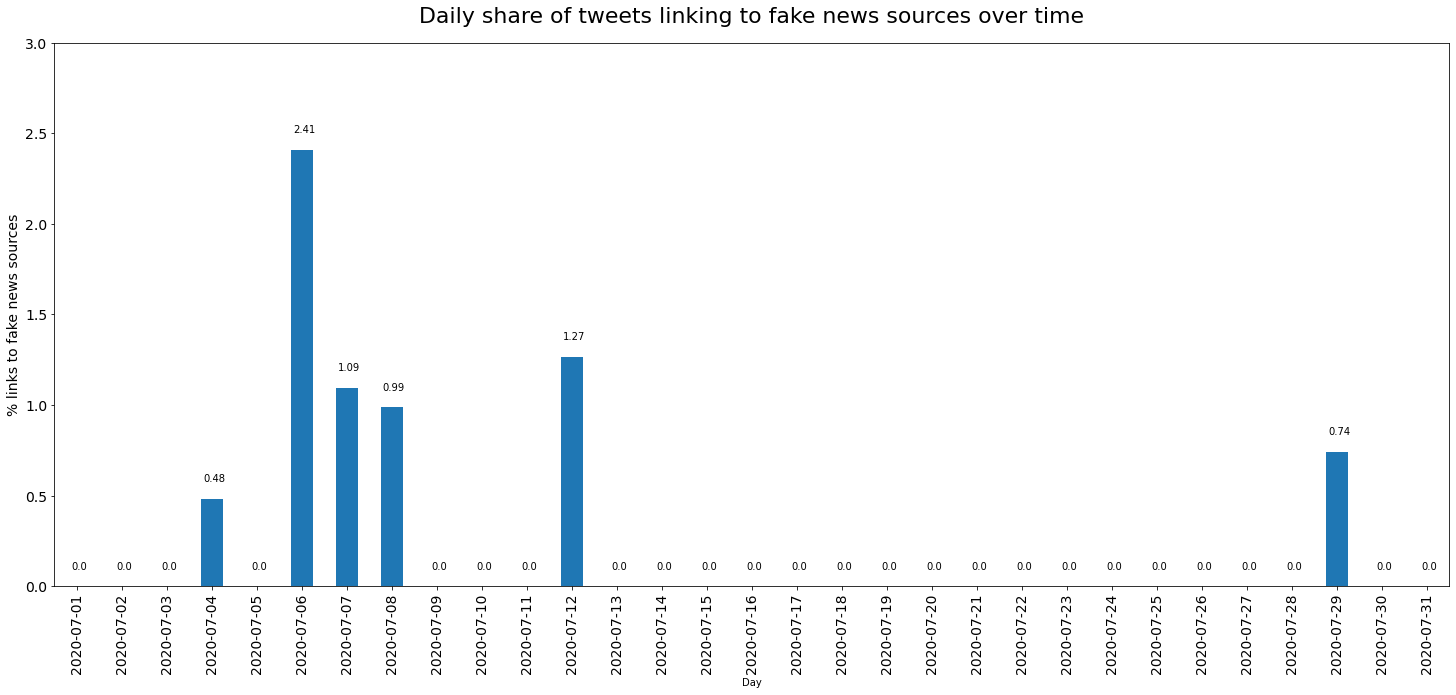

In [21]:
bar_plot_and_save(df=mean_daily_fake, ylabel='% links to fake news sources',
                  xlabel='Day',title='Daily share of tweets linking to fake news sources over time',
                  ylim=[0, 3], legend=False)

as we can see the amount of fake news shared during this month is very high. We can see that around 2% of the tweets being shared contain fake news URL. This is possibly because that during July, USA has passed the 150k death toll mark caused by COVID-19.